## What is bertopic
A topic modeling tool based on bert(a vector space capable to capture the semantic and contextual information)
## Difference to other topic modeling tools
- Based on Bert, not based on BoW in which each word is independent: the meaning is missing
- Topic clustering: cluster similar vectors in high dimensional space. Different to LDA which is a probabilistic model, with some dimensionality reduce techniques, bertopic projects corpus into a vetor space. Then using topic clustering algorithm to calculate similarity. Two ways of topic clustering: centroid-based and Density-based.
- Centroid-based: suppose each class can be represented by a centroid, the algorighm make sure all points in the class has the smallest distance to its centroid(like data are distributed like many balls, each ball is a topic). Methods: K-means. Advan: controllable calculation complexity, comprehensible by humain, and eash to visualize in low dimensional space.
- Hierarchical Clustering
- Density-based: investigate the density of data points in local space whether it is enough to be classed as a topic. For those data that do not belong to any desity level, they are classed as noisy or outliers. So basically, this methods intend to class the space by different level of dentisy. Methods: DBSACN(needs 2 parameters: 邻域半径ϵ and Minpts for a density level) and HDBSCAN. Advan: not sensible to noisies. No need to determine the n of topics which is calculated automaticcaly. Better performance in sparse data and irregular distribution data in high dimensional space. 
## Structure
Vectoriazation + Lower Dimensionality + Topic clustering + topic representation
- Bert: A vector space based on pretrained models like sentence-BERT to transform data into vectors like word2vec but capable to capture more information.
- UMAP: solves curse of dimensionality, the higher the dimensionality is, the closer the data are
- HDBSCAN: topic clustering
- Represent each clusters using c-TF-IDF: For each cluster, we want to find the most representative words for each topic. So, we need to find the most important words, which is the case of IF-IDF which is called c-IF-IDF. Because the importance of a term is based on its cluster (a collection of docs). So we use c-IF-IDF to build a vector space, where each Document of IDF is a topic.


## About Bert word embedding techniques
Stentence Transformer: cross-lingual model, it transforms a sentence into a certain demension vector based on the pretrained model used.
Cross-lingual: because transformers are based on Byte-pair encoding or SentencePiece which can capture some common cross-lingual information 
### How to hindle big corpora
split a complexe question into a group of small questions
image that if we have a corpus, we want to get its vector representation. We gonna use `SentenceTransformer` which accepts a certain length of input(512 tokens for example). We split our corpus into sentences or pragraphs or ... depending on the corpus itself and our task. Then we get a matrix of vectors where each vector is the split result. This is our doc's vector representation, but we want to get a synthesied version. We can do something called pooling: we can just calculate the mean of all vectors and use this as our doc's representation, which is called `mean pooling`, or use `weighted averaing` like TF-IDF. Or, we can choose the most representive paragraphs by choosing the praragraphs which have the higest similarity with other papagraphs, or many other ways like `hierarchical aggregation`, `attention pooling`, `embeddings fusion`.
### Compare Bert with Word2Vec

In [1]:
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
import numpy as np
from scipy.spatial.distance import cosine  

# Sentences to compare
sent1 = "the cat casses the dog"
sent2 = "the dog casses the cat"

# 1. Using BERT (sentence-transformers)
bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
bert_emb1 = bert_model.encode([sent1])[0]
bert_emb2 = bert_model.encode([sent2])[0]
bert_similarity = 1 - cosine(bert_emb1, bert_emb2)  # Convert distance to similarity

# 2. Using Word2Vec
w2v_model = api.load('word2vec-google-news-300')

def sentence_to_vec(sentence, model):
    words = sentence.lower().split()
    word_vecs = []
    for word in words:
        if word in model:
            word_vecs.append(model[word])
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    return np.zeros(model.vector_size)

w2v_emb1 = sentence_to_vec(sent1, w2v_model)
w2v_emb2 = sentence_to_vec(sent2, w2v_model)
w2v_similarity = 1 - cosine(w2v_emb1, w2v_emb2)

# Print results
print("BERT Similarity:", bert_similarity)
print("Word2Vec Similarity:", w2v_similarity)

# Print vector dimensions
print("\nVector dimensions:")
print("BERT:", bert_emb1.shape)
print("Word2Vec:", w2v_emb1.shape)

/home/chen/Desktop/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERT Similarity: 0.9890531301498413
Word2Vec Similarity: 0.9999999949538801

Vector dimensions:
BERT: (384,)
Word2Vec: (300,)


Though the similarity is not very different, we can still find that Word2Vec handles less better the finite meanning than Bert

## Demo
### Tools

In [3]:
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from pathlib import Path
import json
from typing import Generator
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import RegexpTokenizer
from bertopic.vectorizers import ClassTfidfTransformer
import openai
from bertopic.representation import OpenAI
import os

/home/chen/Desktop/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [57]:
def read_json(path:Path,pos:str = None) -> Generator:
    with open(path,'r') as file:
        articles = json.load(file)
        for article in articles:
            if pos:
                data = [word["form"] for analysis in article["analysis"] for word in analysis if word["pos"].lower()==pos.lower()]
                yield " ".join(data)
            else:
                data = article["description"] + " " + article["title"]
                yield data # deal with big data

def preprocesse(data:list,lemma:bool=True) -> None:
    stoplist = set(stopwords.words("french"))
    tokenizer = RegexpTokenizer(r'\w+') 
    if lemma:
        lemmatizer = WordNetLemmatizer()
        for idx in range(len(data)):
            data[idx] = [lemmatizer.lemmatize(token) for token in tokenizer.tokenize(data[idx].lower()) if token not in stoplist and not token.isnumeric() and len(token)>1]
    else:
        for idx in range(len(data)):
            data[idx] = [token for token in tokenizer.tokenize(data[idx].lower()) if token not in stoplist and not token.isnumeric() and len(token)>1]

def show_data(data:list):
    for idx, article in enumerate(data):
        if idx < 5:
            print(article)

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')


In [58]:
data = list(read_json(Path("data/stanza_corpus.json")))
preprocesse(data)
data = [ " ".join(d) for d in data]
show_data(data)

embeddings = embedding_model.encode(data)

réunis tanzanie samedi février dirigeants afrique afrique centrale appelé cessez feu république démocratique congo reprise dialogue entre belligérants rdc rwanda etats voisins tentent faire baisser tension
alors administration trump annoncé couper financements tout projet recherche contenant termes femmes inclusion traumatisme inégalité statut lgbt france doit lancer programme accueil universitaires américains concernés demande historien etats unis président ecole hautes études science sociales science sociales france doit accueillir chercheurs victimes chasse sorcières donald trump
extraction précieux sable minéralisé multinationale déplace depuis village entiers avale terres agricoles laissant derrière communautés amères inquiètes histoire espoir brisé sénégal comment groupe minier français eramet croque grande côte
arrivé tête suffrage premier ministre gauche bonne position poursuivre politique fermeté face serbie reconnaît toujours indépendance pay législatives kosovo nouveau succè

### Lower dimensionality using UMAP

In [71]:
umap_model = UMAP(
    n_neighbors=5,
    n_components=5,
    min_dist=0.05,
    metric='cosine',
    random_state=42
)

### Topic clustering

In [73]:
hdbscan_model = HDBSCAN(
    min_cluster_size=3, # for each class at least 5 data points
    min_samples=2,
    cluster_selection_method="eom",
    metric="euclidean",
    gen_min_span_tree=True
)


## Vectorization of cluters
- IF-IDF
- C-IF-IDF

In [75]:

vectorizer_model = CountVectorizer()
C_if_idf_model = ClassTfidfTransformer()

# use a llm for fine tuning
key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=key)
representation_model = OpenAI(
    client, 
    model="gpt-4o-mini", 
    chat=True
    )

### Train our BerTopic

In [79]:
topic_model = BERTopic(
    n_gram_range=(1,2),
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    min_topic_size=3, # density
    ctfidf_model=C_if_idf_model,
    representation_model=representation_model, # for fine tuning
    # language="multilingual
    #nr_topics=10, max topics
    top_n_words=3 # top n words to represent each topic
)

topics,probs = topic_model.fit_transform(data,embeddings=embeddings) # 动态计算
topic_info = topic_model.get_topic_info()

In [80]:
topic_info
# -1 refers to all outliers

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4,-1_Current events updates,[Current events updates],[ministre culture également annoncé vouloir ré...
1,0,24,0_Fashion and Attractions,[Fashion and Attractions],[sûrement déjà allé parc attraction savez avan...
2,1,12,1_Government Budget Cuts,[Government Budget Cuts],[agence renseignement lance plan départs volon...
3,2,10,2_Geopolitical energy disconnect,[Geopolitical energy disconnect],[lituanie estonie lettonie achevé dimanche int...
4,3,8,3_Political elections and democracy,[Political elections and democracy],[pay plus jeune europe rares région progresser...
5,4,8,4_Trade conflicts Trump,[Trade conflicts Trump],[alors administration trump annoncé couper fin...
6,5,8,5_Trade War Updates,[Trade War Updates],[président américain donald trump suspendu lun...
7,6,8,6_Climate and Tourism Issues,[Climate and Tourism Issues],[décryptage jalon important trajectoire vers n...
8,7,8,7_French cinema industry,[French cinema industry],[tout long vie acteur cherché diversifier sour...
9,8,8,8_Ski station challenges,[Ski station challenges],[fragilisée condition météo difficiles explosi...


### Visualization

In [12]:
hierarchical_topics = topic_model.hierarchical_topics(data)
fig1 = topic_model.visualize_topics()
fig2 = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics) # since BerTopic can returns many topics and some topics are very related to others, we can visualize this and find the main topics 
fig3 = topic_model.visualize_documents(data,embeddings=embeddings)
fig4 = topic_model.visualize_barchart()
fig5 = topic_model.visualize_heatmap()
fig6 = topic_model.visualize_term_rank()
fig1.write_html("1.topics.html")
fig2.write_html("2.topics.html")
fig3.write_html("3.topics.html")
fig4.write_html("4.topics.html")
fig5.write_html("5.topics.html")
fig6.write_html("6.topics.html")


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 273.06it/s]


### Fine tuning
update topics
Reduce outliers

### Some operations to extract data from our model

In [83]:
print(topic_model_tuned.get_topic(topic=0)) # acess single topic


[('Trade war tensions', 1)]


In [85]:
topic_model_tuned.get_document_info(data)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,réunis tanzanie samedi février dirigeants afri...,5,5_Political movements and elections,[Political movements and elections],[deux semaines élections législatives outre rh...,Political movements and elections,0.780548,False
1,alors administration trump annoncé couper fina...,0,0_Trade war tensions,[Trade war tensions],[justin trudeau annoncé lundi soir états unis ...,Trade war tensions,0.765345,False
2,extraction précieux sable minéralisé multinati...,8,8_Pollution and Extraction,[Pollution and Extraction],[décryptage mesures sédiments mer égée retrouv...,Pollution and Extraction,0.432665,True
3,arrivé tête suffrage premier ministre gauche b...,5,5_Political movements and elections,[Political movements and elections],[deux semaines élections législatives outre rh...,Political movements and elections,1.000000,False
4,si dit avoir reçu notification hausse droits d...,0,0_Trade war tensions,[Trade war tensions],[justin trudeau annoncé lundi soir états unis ...,Trade war tensions,0.670282,False
...,...,...,...,...,...,...,...,...
140,reportage gennevilliers mairie association mob...,2,2_Challenges for ski stations,[Challenges for ski stations],[fragilisée condition météo difficiles explosi...,Challenges for ski stations,0.839180,False
141,récit situé nord chili observatoire américain ...,2,2_Challenges for ski stations,[Challenges for ski stations],[fragilisée condition météo difficiles explosi...,Challenges for ski stations,0.988151,False
142,décryptage étude montre surtout bombes américa...,8,8_Pollution and Extraction,[Pollution and Extraction],[décryptage mesures sédiments mer égée retrouv...,Pollution and Extraction,1.000000,False
143,décryptage jalon important trajectoire vers ne...,2,2_Challenges for ski stations,[Challenges for ski stations],[fragilisée condition météo difficiles explosi...,Challenges for ski stations,0.646725,False


In [89]:
topics = topic_model_tuned.get_topic_info()
topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4,-1_Current events and media,[Current events and media],[ministre culture également annoncé vouloir ré...
1,0,38,0_Trade war tensions,[Trade war tensions],[justin trudeau annoncé lundi soir états unis ...
2,1,36,1_French entertainment industry,[French entertainment industry],[sûrement déjà allé parc attraction savez avan...
3,2,16,2_Challenges for ski stations,[Challenges for ski stations],[fragilisée condition météo difficiles explosi...
4,3,15,3_Baltic electricity independence,[Baltic electricity independence],[trois pay baltes intégrés union européenne ot...
5,4,13,4_Libération des otages,[Libération des otages],[libération fait point conflit entre hamas isr...
6,5,8,5_Political movements and elections,[Political movements and elections],[deux semaines élections législatives outre rh...
7,6,6,6_Nature and market dynamics,[Nature and market dynamics],[décryptage impressionnante crise sismique vit...
8,7,5,7_Frequency renewal disputes,[Frequency renewal disputes],[groupe nrj va déposer recours auprès conseil ...
9,8,4,8_Pollution and Extraction,[Pollution and Extraction],[décryptage mesures sédiments mer égée retrouv...


In [86]:
# a dict behave type
doc = topic_model_tuned.get_document_info(data)["Representative_Docs"][0]

In [45]:
# save model
topic_model_tuned.save("fine_tuned_model",serialization="safetensors")
topic_model.save("Bertopic_model",serialization="safetensors")

In [ ]:
# load model, the traning data will not be save
load_finte_tuned = BERTopic.load("fine_tuned_model",embedding_model=SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2'))
load_bert = BERTopic.load("Bertopic_model",embedding_model=SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2'))
# 

In [105]:
data_new = ["De l’immigration à la guerre dans la bande de Gaza ou le gel de l’aide humanitaire internationale, les sujets de friction entre Washington et le Vatican ne manquent pas. La rencontre, samedi, entre le vice-président des Etats-Unis et le cardinal Parolin, numéro deux du Saint-Siège, doit en partie solder la dispute et rappeler l’unité de l’Eglise."]
topic_new, probs_new = load_bert.transform(data_new)

print(f"topic of new data: {topic_new} which is {load_bert.get_topic(topic_new[0])[0][0]} with a prob of {probs_new[0]}")

topic of new data: [4] which is Libération otages Gaza with a prob of 0.45695263147354126


In [94]:
topic_info = load_bert.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4,-1_Current global events,[Current global events],NaN
1,0,38,0_Guerre commerciale États-Unis,[Guerre commerciale États-Unis],NaN
2,1,36,1_Culture and Entertainment,[Culture and Entertainment],NaN
3,2,16,2_Ski station challenges,[Ski station challenges],NaN
4,3,15,3_Energy independence transition,[Energy independence transition],NaN
5,4,13,4_Libération otages Gaza,[Libération otages Gaza],NaN
6,5,8,5_Political Elections and Democracy,[Political Elections and Democracy],NaN
7,6,6,6_Environmental research trends,[Environmental research trends],NaN
8,7,5,7_TNT Frequency Renewals,[TNT Frequency Renewals],NaN
9,8,4,8_Pollution and industrial impact,[Pollution and industrial impact],NaN


## Build a Bertopic by ourself

### 1. Word embedding

In [1]:
sentences = [
    # Phrases sur la météo
    "La tempête a provoqué des inondations dans plusieurs régions côtières hier soir.",
    "Les prévisions météorologiques annoncent un temps ensoleillé pour tout le week-end.",
    "L'hiver dernier a été particulièrement froid avec des températures descendant jusqu'à -15°C.",
    "Un épais brouillard s'est installé sur la ville ce matin, réduisant la visibilité à quelques mètres.",
    "La canicule persistante a battu des records de température dans plusieurs villes du sud.",
    "Les agriculteurs espèrent des précipitations dans les prochains jours pour sauver leurs cultures.",
    "Le vent violent a arraché plusieurs arbres et endommagé des toitures dans le quartier.",
    "L'humidité élevée rend la chaleur encore plus difficile à supporter aujourd'hui.",
    "Un arc-en-ciel magnifique est apparu après l'averse de cet après-midi.",
    "Les météorologues prévoient un automne plus chaud que la normale cette année.",
    
    # Phrases sur le NLP
    "Les modèles de transformers ont révolutionné le traitement du langage naturel depuis 2018.",
    "L'apprentissage par transfert permet d'adapter des modèles linguistiques à des tâches spécifiques.",
    "La tokenisation est une étape cruciale dans le prétraitement des données textuelles.",
    "BERT a marqué une avancée significative en capturant le contexte bidirectionnel des mots.",
    "L'attention est un mécanisme qui permet aux modèles de se concentrer sur les parties pertinentes d'une séquence.",
    "Les word embeddings représentent les mots dans un espace vectoriel continu.",
    "Le fine-tuning consiste à ajuster un modèle pré-entraîné sur un corpus spécifique.",
    "La reconnaissance d'entités nommées est une tâche fondamentale en extraction d'information.",
    "Les modèles multilingues peuvent traiter efficacement plusieurs langues avec une seule architecture.",
    "L'évaluation des modèles de génération de texte reste un défi majeur en NLP."
]

In [5]:
embedding_model = SentenceTransformer("dangvantuan/sentence-camembert-base")
embeddings = embedding_model.encode(sentences)
print(embeddings.shape, embeddings)

(20, 768) [[-0.01025722  0.04177687 -0.2273639  ...  0.22829558  0.1961667
   0.05641668]
 [-0.05740656 -0.03119146 -0.06102162 ...  0.17400885  0.14730765
   0.03451753]
 [ 0.04899164 -0.16157585 -0.1972949  ...  0.14858171  0.02258325
  -0.00183562]
 ...
 [ 0.08897563  0.1353907  -0.26507342 ...  0.02865572 -0.03049049
  -0.0164471 ]
 [-0.01155569  0.2491225  -0.1717322  ... -0.07203957  0.05167952
  -0.15898955]
 [-0.04817954  0.18282564 -0.1426191  ... -0.04707405  0.032332
  -0.00364248]]


### 2. Reducing dimensionality

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
print(reduced_embeddings.shape, reduced_embeddings)

(20, 2) [[-1.2525064  -0.96847224]
 [-1.4011917  -0.43477476]
 [-1.0734665   1.336559  ]
 [-1.1208297   0.05924867]
 [-1.0393478   0.83393097]
 [-1.1334828  -0.94038737]
 [-0.87662905 -0.71724105]
 [-1.0920854   0.81116074]
 [-1.1041651  -0.4952285 ]
 [-1.3371707   0.79607034]
 [ 0.98889714 -0.6086606 ]
 [ 1.1706855  -0.5381844 ]
 [ 1.0980732   1.0145339 ]
 [ 1.396133    0.28289065]
 [ 1.1494833  -0.68348527]
 [ 1.025191    0.04662155]
 [ 1.2198969  -0.28630906]
 [ 1.131776    1.0651664 ]
 [ 0.87797993 -1.3062295 ]
 [ 1.3727589   0.7327898 ]]


In [9]:
umap_model = UMAP(n_components=2)
reduced_embeddings2 = umap_model.fit_transform(embeddings)
print(reduced_embeddings.shape, reduced_embeddings)

(20, 2) [[-1.2525064  -0.96847224]
 [-1.4011917  -0.43477476]
 [-1.0734665   1.336559  ]
 [-1.1208297   0.05924867]
 [-1.0393478   0.83393097]
 [-1.1334828  -0.94038737]
 [-0.87662905 -0.71724105]
 [-1.0920854   0.81116074]
 [-1.1041651  -0.4952285 ]
 [-1.3371707   0.79607034]
 [ 0.98889714 -0.6086606 ]
 [ 1.1706855  -0.5381844 ]
 [ 1.0980732   1.0145339 ]
 [ 1.396133    0.28289065]
 [ 1.1494833  -0.68348527]
 [ 1.025191    0.04662155]
 [ 1.2198969  -0.28630906]
 [ 1.131776    1.0651664 ]
 [ 0.87797993 -1.3062295 ]
 [ 1.3727589   0.7327898 ]]


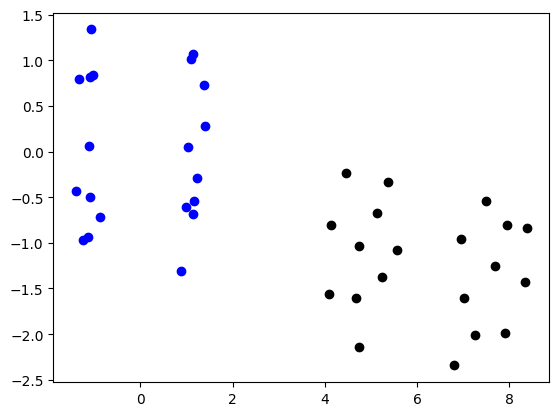

In [14]:
import matplotlib.pyplot as plt
plt.scatter(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1],color="blue")
plt.scatter(x=reduced_embeddings2[:,0], y=reduced_embeddings2[:,1],color="black")

### Topic clustering

In [15]:
hdbscan_model = HDBSCAN(
    min_cluster_size=5
)
hdbscan_model.fit(reduced_embeddings)
hdbscan_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Word vectorizer
In this step we count words of all topics

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
french_stop_words = [
    "le", "la", "les", "des", "un", "une", "du", "de", "et", "est", "dans", "pour",
    "en", "sur", "a", "au", "aux", "avec", "ce", "ces", "cette", "ont", "par", "plus",
    "qui", "que", "se", "sont", "un", "une", "plusieurs", "est"
]
word_vectorizer = CountVectorizer(stop_words=french_stop_words)
top1 = ""
top2 = ""
for idx, label in enumerate(hdbscan_model.labels_):
    if label == 0:
        top1 += sentences[idx]
    else:
        top2 += sentences[idx]

bow = word_vectorizer.fit_transform([top1, top2])
vocab = word_vectorizer.get_feature_names_out()
print(len(word_vectorizer.get_feature_names_out()), word_vectorizer.get_feature_names_out()[:5])

bow_array = bow.toarray()
print(bow_array.shape, bow_array)

149 ['15' '2018' 'adapter' 'agriculteurs' 'ajuster']
(2, 149) [[1 0 0 1 0 1 1 1 0 2 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1
  1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1
  0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0
  1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
  1 1 0 1 0]
 [0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0
  0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0
  1 1 0 0 1 5 2 1 0 1 0 0 1 1 1 0 0 1 2 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1
  0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1
  0 0 1 0 1]]


### TF-IDF
Use this to find the most representative words for each topic
get top 5 words for each topic

In [48]:
idf_model = ClassTfidfTransformer()
c_tf_idf = idf_model.fit_transform(bow).toarray()
print(c_tf_idf.shape, c_tf_idf[:1, :10])

(2, 149) [[0.05530947 0.         0.         0.05530947 0.         0.05530947
  0.05530947 0.05530947 0.         0.09338935]]


In [49]:
top1_n_words_idx = np.argsort(c_tf_idf[0])[::-1]

top2_n_words_idx = np.argsort(c_tf_idf[1])[::-1]

for i in range(5):
    print(vocab[top1_n_words_idx[i]], vocab[top2_n_words_idx[i]])

après modèles
matin permet
jusqu mots
ensoleillé mécanisme
espèrent corpus
